# Overall Take Aways from EDA 
- **Price and distribution** are independent but complementary drivers of sales.  
- **Distribution (SellingStoresRatio)** shows a consistently strong positive relationship with sales, confirming that **availability is a key volume driver**.  
- **Price sensitivity varies by segment:**  
  - The overall correlation between `SalesQuantity` and `NewBasePrice` is weak — close to zero at both the Category and SubCategory levels.  
  - This suggests that **price does not systematically influence sales volume** across all items; for some products, sales appear largely **insensitive to price changes**, while others may still respond to pricing shifts within their specific segment.  
  - In other words, **price elasticity is item- or segment-specific**, not a universal pattern in this dataset.
- **Territory differences** add an additional layer of variability — regional factors likely influence both sales and distribution coverage.  
- **Outlier effects** modestly influence correlations (Δ typically within 0.05–0.15), but core relationships remain stable after removing extreme data points.  
- **Category and SubCategory segmentation** remain important, as structural differences in sales and distribution patterns persist across product types and territories.
- **SalesQuantity distribution is skewed** → suggesting the merit of using log transformation or outlier handling before modeling.

In [1]:
# load packages
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# load file
df = pd.read_csv("1C_Sales_top80_items_all_dates.csv")

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4798 entries, 0 to 4797
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   ItemID              4798 non-null   object 
 1   year                4798 non-null   int64  
 2   WeekIdentifier      4798 non-null   int64  
 3   SalesChannel        4798 non-null   object 
 4   Territory           4798 non-null   object 
 5   NewBasePrice        4798 non-null   float64
 6   SellingStoresRatio  4798 non-null   float64
 7   SalesQuantity       4798 non-null   float64
 8   revenues            4798 non-null   float64
 9   Category            4798 non-null   object 
 10  SubCategory         4798 non-null   object 
dtypes: float64(4), int64(2), object(5)
memory usage: 412.5+ KB


## Simplify Category, SubCategory and ItemID names

In [4]:
# Get # of unique categories, sub-categories and items

# Number of unique values in each key column
unique_counts = {
    'Category': df['Category'].nunique(),
    'SubCategory': df['SubCategory'].nunique(),
    'ItemID': df['ItemID'].nunique()
}

# Display results neatly
for col, count in unique_counts.items():
    print(f"{col}: {count} unique values")


Category: 5 unique values
SubCategory: 11 unique values
ItemID: 202 unique values


In [5]:
# Create simplified columns
df['Cat'] = df['Category'].astype(str).str[:4]
df['SubCat'] = df['SubCategory'].astype(str).str[:4]
df['Item'] = df['ItemID'].astype(str).str[:5]

# confirm that we maintained unique counts

# Number of unique values in each key column
unique_counts = {
    'Cat': df['Cat'].nunique(),
    'SubCat': df['SubCat'].nunique(),
    'Item': df['Item'].nunique()
}

# Display results neatly
for col, count in unique_counts.items():
    print(f"{col}: {count} unique values")


Cat: 5 unique values
SubCat: 11 unique values
Item: 202 unique values


## Get Summary Statistics

In [6]:
# Get summary statistics for selected columns
summary_all = df[['SalesQuantity', 'NewBasePrice', 'SellingStoresRatio']].describe().round(2)

# Display results
summary_all

,SalesQuantity,NewBasePrice,SellingStoresRatio
count,4798.00,4798.00,4798.00
mean,36.32,20.03,0.20
std,53.26,3.93,0.21
min,0.00,10.88,0.00
25%,7.00,17.33,0.07
50%,15.00,20.21,0.12
75%,44.00,22.75,0.27
max,686.00,38.00,1.08


In [7]:
# oh, my.  did not catch that some SalesQuantity entries are zero during the Cleaning phase.
# determine magnitude of problem

zero_count = (df['SalesQuantity'] == 0).sum()
print(f"Number of rows with SalesQuantity = 0: {zero_count}")


Number of rows with SalesQuantity = 0: 39


In [8]:
# The problem is not pervasive, only 39 of 4798 rows.
# will drop these rows

df = df[df['SalesQuantity'] != 0]


In [9]:
# Get new summary statistics for selected columns
summary_all = df[['SalesQuantity', 'NewBasePrice', 'SellingStoresRatio']].describe().round(2)

# Display results
summary_all

,SalesQuantity,NewBasePrice,SellingStoresRatio
count,4759.00,4759.00,4759.00
mean,36.61,20.02,0.21
std,53.38,3.92,0.21
min,1.00,10.88,0.00
25%,7.00,17.33,0.07
50%,16.00,20.21,0.12
75%,45.00,22.75,0.27
max,686.00,38.00,1.08


In [10]:
# Get Summary statistics by Category
summary_by_cat = (
    df.groupby('Category')[['SalesQuantity', 'NewBasePrice', 'SellingStoresRatio']]
      .describe()
      .round(2)
)

# Display results
summary_by_cat


SalesQuantity                                             \
                 count   mean    std  min  25%   50%   75%    max   
Category                                                            
4ThiCT_Z        1663.0  44.78  62.31  1.0  8.0  19.0  58.0  577.0   
H80alU8y         203.0  32.48  40.20  2.0  7.0  15.0  48.5  255.0   
HZlnatsW        1115.0  24.47  34.81  1.0  6.0  12.0  29.0  332.0   
bwPDJC3m         662.0  31.54  45.17  1.0  6.0  13.0  40.0  499.0   
xF4EZaTy        1116.0  40.35  58.12  1.0  7.0  15.0  55.0  686.0   

         NewBasePrice         ...               SellingStoresRatio        \
                count   mean  ...    75%    max              count  mean   
Category                      ...                                          
4ThiCT_Z       1663.0  20.31  ...  22.86  38.00             1663.0  0.20   
H80alU8y        203.0  23.07  ...  25.29  26.21              203.0  0.18   
HZlnatsW       1115.0  19.99  ...  22.73  30.51             1115.0  0.22   
bwPDJC3m        662.0  21.43  ...  22.99  26.21              662.0  0.15   
xF4EZaTy       1116.0  18.24  ...  20.72  27.33             1116.0  0.23   

                                              
           std   min   25%   50%   75%   max  
Category                                      
4ThiCT_Z  0.19  0.00  0.07  0.12  0.28  1.07  
H80alU8y  0.17  0.01  0.08  0.11  0.26  0.80  
HZlnatsW  0.24  0.00  0.07  0.12  0.27  1.08  
bwPDJC3m  0.15  0.01  0.05  0.10  0.18  1.03  
xF4EZaTy  0.24  0.00  0.07  0.12  0.32  1.07  

[5 rows x 24 columns]

In [11]:
# Summary statistics by SubCategory
summary_by_subcat = (
    df.groupby('SubCategory')[['SalesQuantity', 'NewBasePrice', 'SellingStoresRatio']]
      .describe()
      .round(2)
)

summary_by_subcat

SalesQuantity                                              \
                    count   mean    std  min  25%   50%    75%    max   
SubCategory                                                             
14iCK1vp            341.0  21.63  21.00  1.0  6.0  11.0  34.00  108.0   
8qImFANZ             13.0  35.85  29.96  8.0  9.0  11.0  69.00   75.0   
AunzRwr2            787.0  43.67  64.53  1.0  6.0  14.0  57.50  686.0   
Mm5PoR88           1245.0  44.71  61.44  1.0  8.0  19.0  57.00  487.0   
OzTP0IWS            147.0  15.37  13.90  1.0  5.0  10.0  23.50   74.0   
UIpuKoxR             85.0  35.78  48.45  2.0  8.0  15.0  53.00  314.0   
WeHSHJQJ            405.0  45.25  65.71  1.0  8.0  20.0  59.00  577.0   
qE16z6jO            203.0  32.48  40.20  2.0  7.0  15.0  48.50  255.0   
sldfL1J4            244.0  31.22  33.08  1.0  8.0  17.0  45.25  144.0   
xdDed-iG            662.0  31.54  45.17  1.0  6.0  13.0  40.00  499.0   
yo2ZtUyf            627.0  28.14  42.83  1.0  6.0  13.0  30.00  332.0   

            NewBasePrice         ...               SellingStoresRatio        \
                   count   mean  ...    75%    max              count  mean   
SubCategory                      ...                                          
14iCK1vp           341.0  19.75  ...  22.16  25.50              341.0  0.15   
8qImFANZ            13.0  15.60  ...  17.78  18.78               13.0  0.26   
AunzRwr2           787.0  18.43  ...  20.72  27.33              787.0  0.24   
Mm5PoR88          1245.0  19.50  ...  21.73  27.68             1245.0  0.20   
OzTP0IWS           147.0  21.44  ...  23.68  28.68              147.0  0.12   
UIpuKoxR            85.0  22.48  ...  25.16  25.16               85.0  0.24   
WeHSHJQJ           405.0  22.93  ...  24.64  38.00              405.0  0.21   
qE16z6jO           203.0  23.07  ...  25.29  26.21              203.0  0.18   
sldfL1J4           244.0  16.17  ...  18.13  23.28              244.0  0.21   
xdDed-iG           662.0  21.43  ...  22.99  26.21              662.0  0.15   
yo2ZtUyf           627.0  19.77  ...  22.08  30.51              627.0  0.29   

                                                 
              std   min   25%   50%   75%   max  
SubCategory                                      
14iCK1vp     0.14  0.00  0.06  0.11  0.20  0.99  
8qImFANZ     0.21  0.04  0.06  0.14  0.47  0.51  
AunzRwr2     0.25  0.00  0.07  0.12  0.34  1.07  
Mm5PoR88     0.19  0.00  0.07  0.12  0.27  1.07  
OzTP0IWS     0.09  0.00  0.05  0.10  0.15  0.47  
UIpuKoxR     0.23  0.01  0.07  0.13  0.39  1.06  
WeHSHJQJ     0.19  0.00  0.07  0.13  0.27  0.99  
qE16z6jO     0.17  0.01  0.08  0.11  0.26  0.80  
sldfL1J4     0.19  0.01  0.08  0.13  0.27  0.80  
xdDed-iG     0.15  0.01  0.05  0.10  0.18  1.03  
yo2ZtUyf     0.28  0.00  0.09  0.15  0.43  1.08  

[11 rows x 24 columns]

### Key Takeaways for the Summary Statistics

1. **SalesQuantity distribution is skewed** → suggesting the merit of using log transformation or outlier handling before modeling.  
2. **NewBasePrice variability is moderate**, suggesting that **relative price** (vs. category average) may be more predictive than absolute price.  
3. **SellingStoresRatio is crucial** — its variation aligns strongly with differences in sales quantity.  
4. **Category/SubCategory effects are clear** — model segmentation or dummy variables for these groups will likely improve predictive accuracy.  
5. There may be **interaction effects**: categories with broader store coverage appear less price-sensitive, while limited-distribution items might show sharper volume declines when prices rise.


# Check Distribution of Data

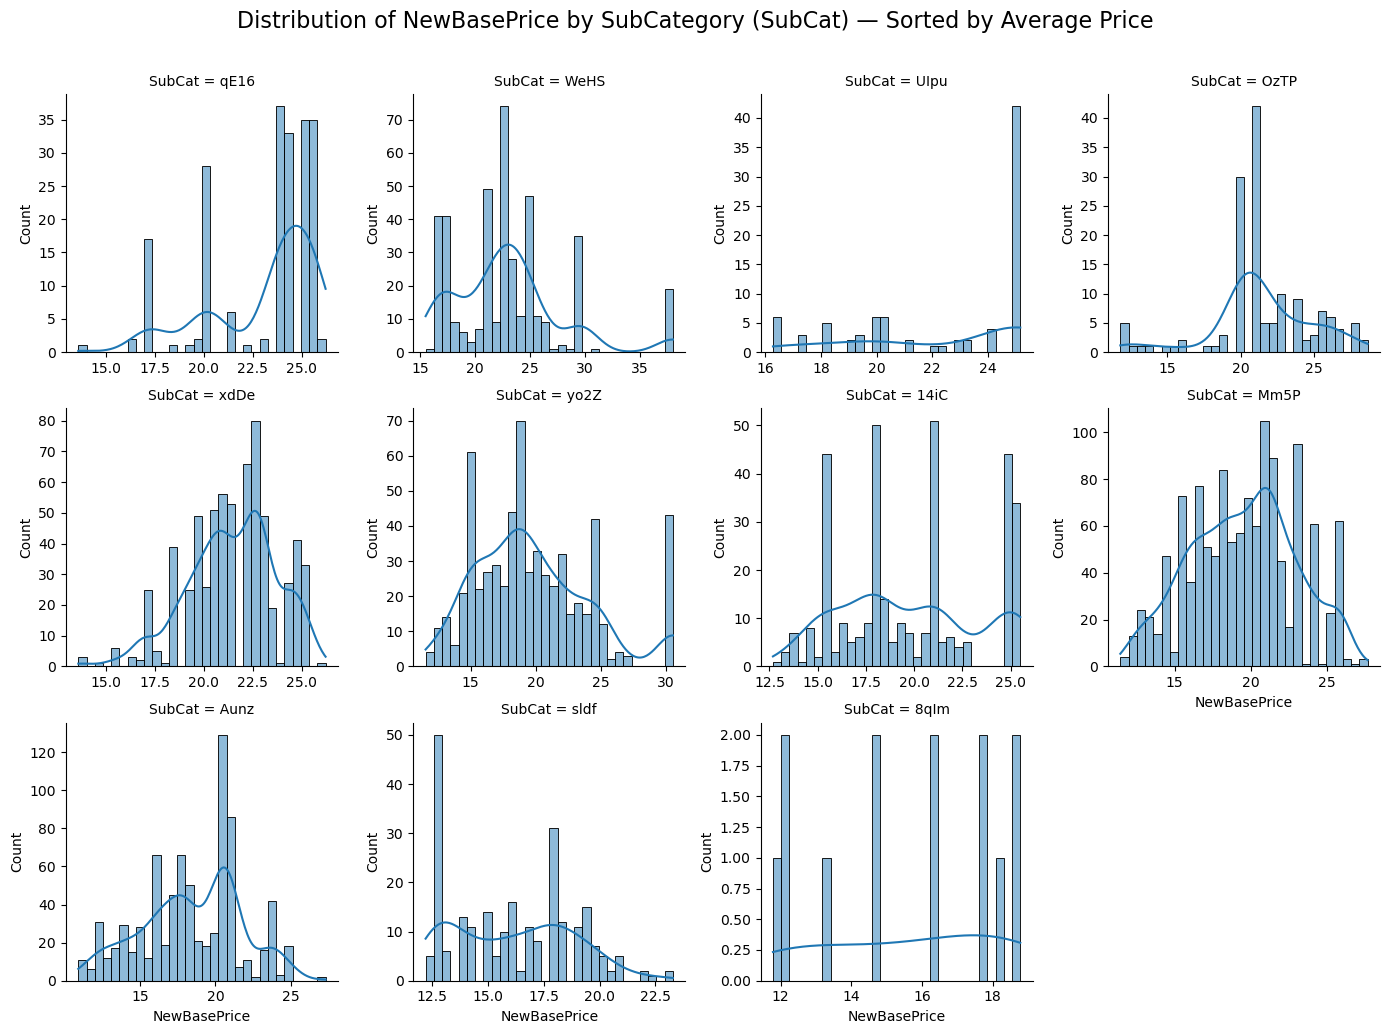

In [12]:
# Compute average NewBasePrice by SubCat
subcat_order = (
    df.groupby('SubCat')['NewBasePrice']
    .mean()
    .sort_values(ascending=False)
    .index
)

# Create subplots (Faceted histograms) in sorted order
g = sns.FacetGrid(df, col='SubCat', col_wrap=4, height=3.5, sharex=False, sharey=False, col_order=subcat_order)
g.map(sns.histplot, 'NewBasePrice', bins=30, kde=True)

# Add title and adjust layout
g.fig.suptitle('Distribution of NewBasePrice by SubCategory (SubCat) — Sorted by Average Price', fontsize=16)
plt.tight_layout()
plt.subplots_adjust(top=0.9)

g.savefig("2A_NewBasePrice_by_SubCat.png", dpi=300)

plt.show()

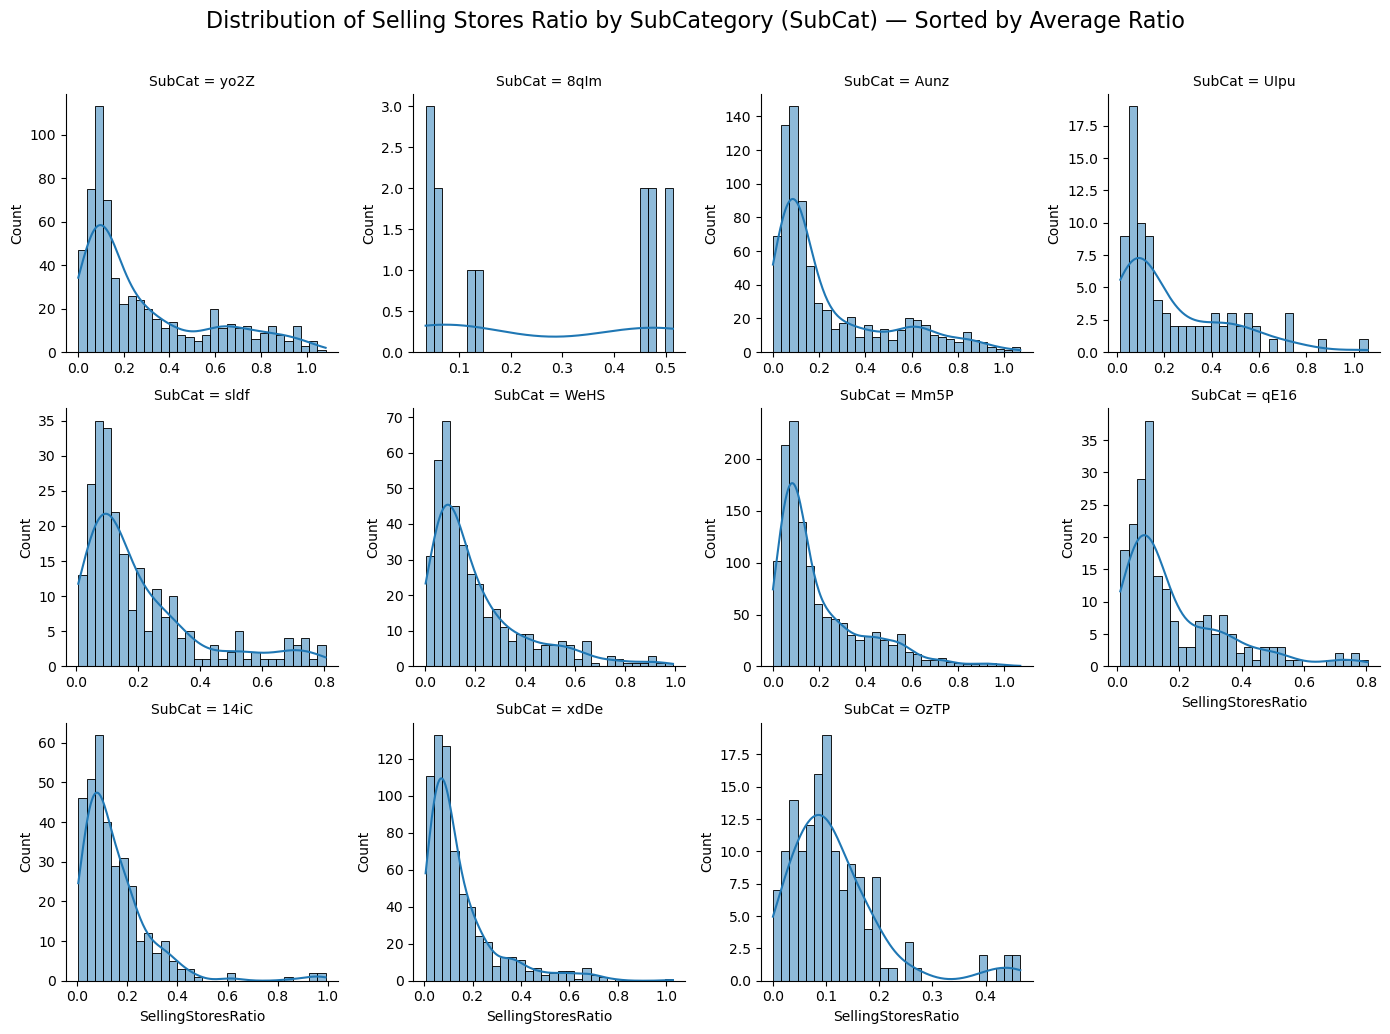

In [13]:
# Compute average SellingStoresRadio by SubCat
subcat_order = (
    df.groupby('SubCat')['SellingStoresRatio']
    .mean()
    .sort_values(ascending=False)
    .index
)

# Create subplots (Faceted histograms) in sorted order
g = sns.FacetGrid(df, col='SubCat', col_wrap=4, height=3.5, sharex=False, sharey=False, col_order=subcat_order)
g.map(sns.histplot, 'SellingStoresRatio', bins=30, kde=True)

# Add title and adjust layout
g.fig.suptitle('Distribution of Selling Stores Ratio by SubCategory (SubCat) — Sorted by Average Ratio', fontsize=16)
plt.tight_layout()
plt.subplots_adjust(top=0.9)

g.savefig("2B_SellingStores_by_SubCategory.png", dpi=300)

plt.show()

### Key Takeaways for the Histograms

1. **Histograms confirm Selling Stores Ratio distribution is skewed** 
2. **Category/SubCategory effects are clear** 

# Check Distribution Differences between Sales Territories

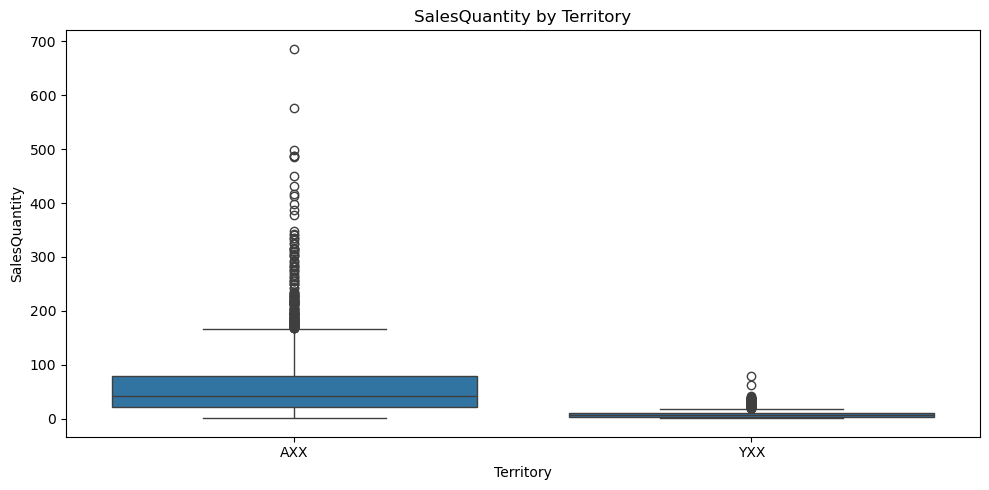

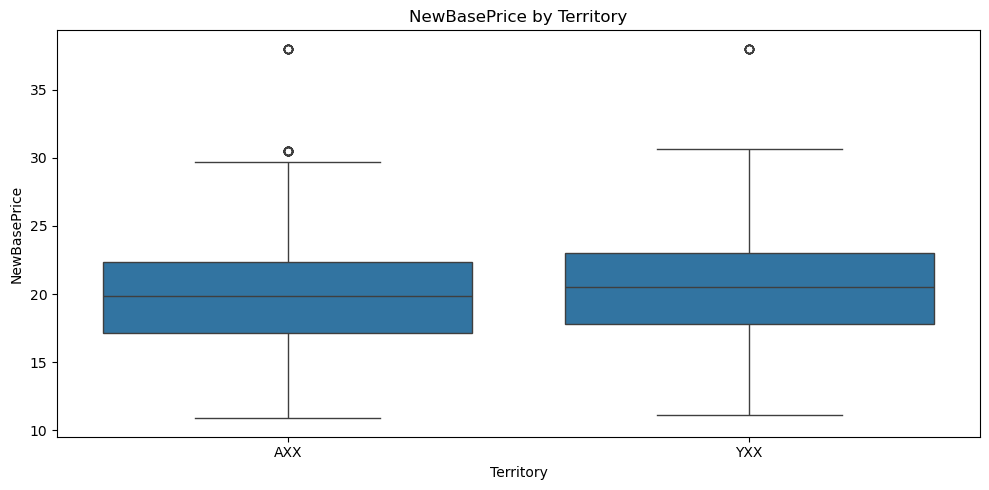

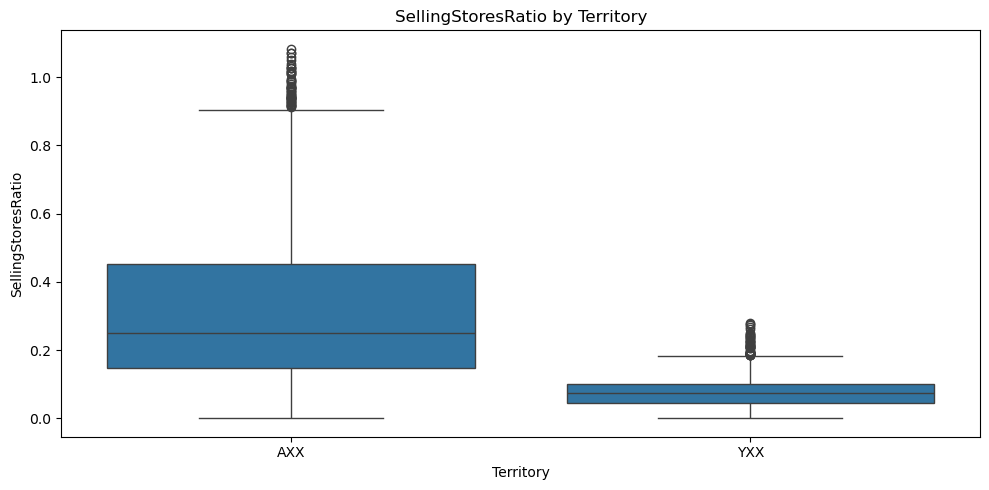

In [17]:
#opted to use a different plot for variation

plt.figure(figsize=(10,5))
sns.boxplot(data=df, x='Territory', y='SalesQuantity')
plt.title('SalesQuantity by Territory')
plt.tight_layout()
plt.savefig("2BP_Quantity_by_Territory.png", dpi=300, bbox_inches='tight')
plt.show()

plt.figure(figsize=(10,5))
sns.boxplot(data=df, x='Territory', y='NewBasePrice')
plt.title('NewBasePrice by Territory')
plt.tight_layout()
plt.savefig("2BP_NewBasePrice_by_Territory.png", dpi=300, bbox_inches='tight')
plt.show()

plt.figure(figsize=(10,5))
sns.boxplot(data=df, x='Territory', y='SellingStoresRatio')
plt.title('SellingStoresRatio by Territory')
plt.savefig("2BP_SellingStoresRatio_by_Territory.png", dpi=300, bbox_inches='tight')
plt.tight_layout()
plt.show()


### Key Takeaways for the Boxplots

The boxplots collectively confirm that **Territory effects are material** — differences in both central tendency and spread across regions suggest that:
- Demand and distribution are geographically uneven.  
- Territory captures structural differences (consumer base, distribution reach, or pricing strategy).  

# Check Relationship between SalesQuantity and New Base Price

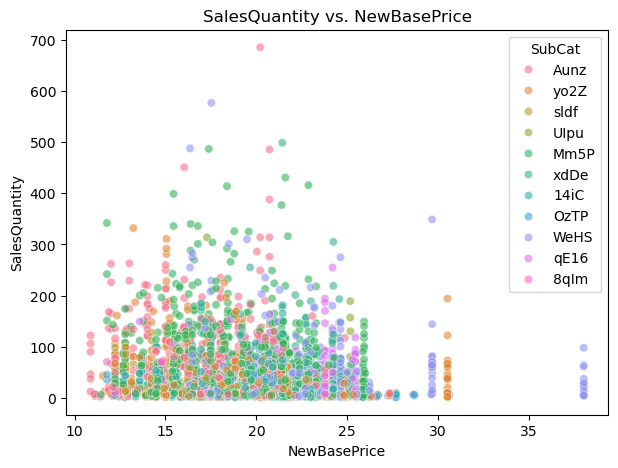

In [16]:
# scatter plot 
plt.figure(figsize=(7,5))
sns.scatterplot(
    data=df,
    x='NewBasePrice',
    y='SalesQuantity',
    hue='SubCat',
    alpha=0.6
)
plt.title('SalesQuantity vs. NewBasePrice')
plt.xlabel('NewBasePrice')
plt.ylabel('SalesQuantity')
plt.savefig("2_Quantity_vs_Price.png", dpi=300, bbox_inches='tight')
plt.show()


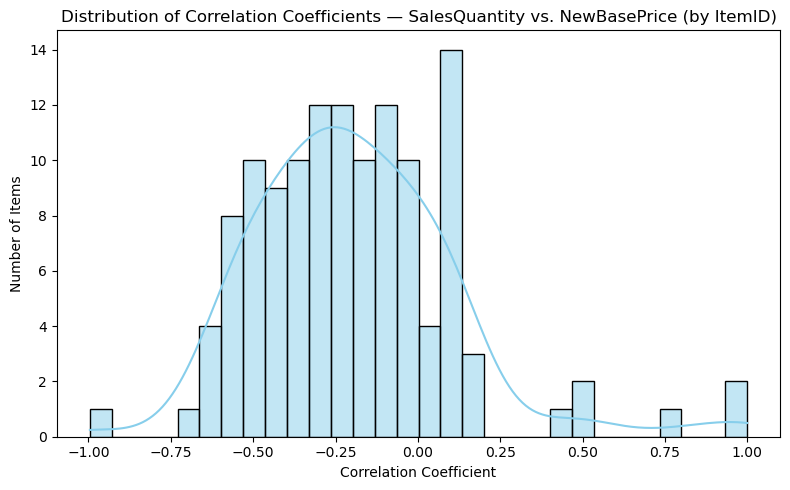

In [16]:
# Calculate correlation by ItemID
corr_by_item = (
    df.groupby('ItemID')[['SalesQuantity', 'NewBasePrice']]
      .corr()
      .unstack()
      .iloc[:, 1]
      .rename('Correlation')
      .reset_index()
)

# Plot histogram
plt.figure(figsize=(8, 5))
sns.histplot(
    data=corr_by_item,
    x='Correlation',
    bins=30,
    kde=True,
    color='skyblue'
)
plt.title('Distribution of Correlation Coefficients — SalesQuantity vs. NewBasePrice (by ItemID)')
plt.xlabel('Correlation Coefficient')
plt.ylabel('Number of Items')
plt.tight_layout()
plt.savefig("2D_Sales_Price_Correlation_by_Item.png", dpi=300, bbox_inches='tight')
plt.show()


In [17]:
high_corr_items = corr_by_item[corr_by_item['Correlation'] > 0.5]
low_corr_items = corr_by_item[corr_by_item['Correlation'] < -0.5]

print("Highly positive correlations:\n", high_corr_items)
print("\nHighly negative correlations:\n", low_corr_items)

Highly positive correlations:
         ItemID  Correlation
14   2vtNwtI19     0.798016
59   GANFtF414     0.999804
153  htWS-NY27     0.965046
193  vSGR_q473     0.533375

Highly negative correlations:
         ItemID  Correlation
0    -Wz4IhI48    -0.547891
3    -qnpdKU51    -0.995730
15   2x7RS8U29    -0.514492
16   3D6u9p054    -0.570155
22   4It1-fI21    -0.548607
34   7n5yN_M74    -0.528363
38   8vk1FOg25    -0.598666
42   9Exgb9I89    -0.592398
52   DLq38H829    -0.709222
57   EG39mrA84    -0.582493
78   LBs6nUA49    -0.625052
93   PlZ1-PY70    -0.528147
116  WEyHpmw12    -0.532864
119  XH8zvtQ30    -0.605051
176  oZKoYOU30    -0.626478
180  pWg7qOk67    -0.543467
196  wJicCFw87    -0.545690


### Key Takeaways for analysis of relationship between SalesQuantity and NewBasePrice

1. **Only Item level correlation** There is strong negative correlation between SalesQuantity and NewBasePrice only in select Items
2. **A few unusual observationsr** In 4 items, there is a positive correlation between SalesQuantity and NewBasePrice. This is unusual as typically sales units increase when price decreases.

# Check Relationship between SalesQuantity and SellingStoresRatio

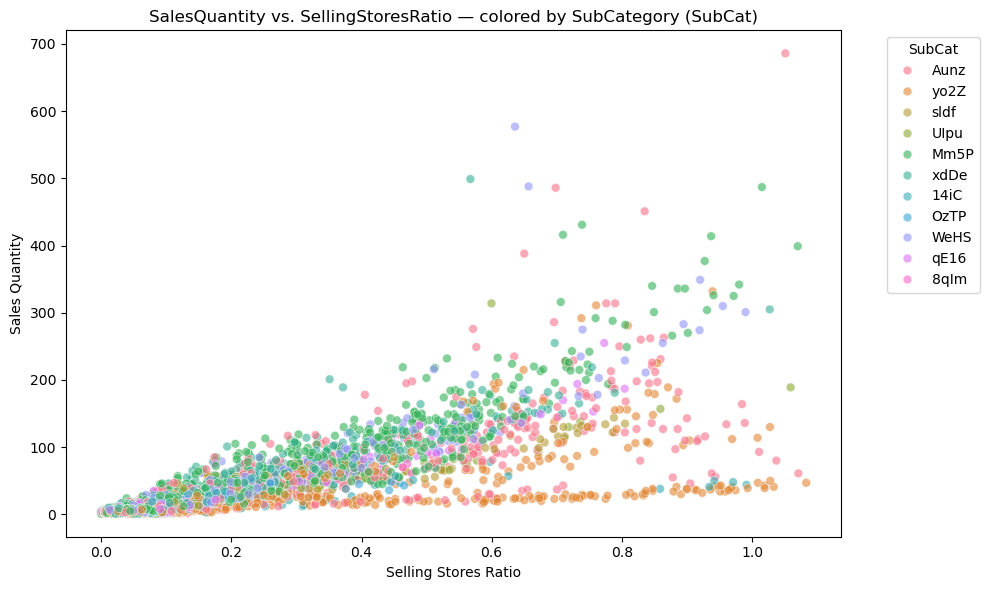

In [18]:
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=df,
    x='SellingStoresRatio',
    y='SalesQuantity',
    hue='SubCat',
    alpha=0.6,         # transparency helps with overlap
    s=40               # point size
)

plt.title('SalesQuantity vs. SellingStoresRatio — colored by SubCategory (SubCat)')
plt.xlabel('Selling Stores Ratio')
plt.ylabel('Sales Quantity')
plt.legend(title='SubCat', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig("2E_Quantity_vs_SellingStoresRatio.png", dpi=300, bbox_inches='tight')
plt.show()


In [19]:
# Define function to detect outliers
def detect_outliers(series):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    return series[(series < lower) | (series > upper)]

# Identify outliers for each variable
outliers_sales = detect_outliers(df['SalesQuantity'])
outliers_stores = detect_outliers(df['SellingStoresRatio'])

print(f"SalesQuantity outliers: {len(outliers_sales)}")
print(f"SellingStoresRatio outliers: {len(outliers_stores)}")


SalesQuantity outliers: 457
SellingStoresRatio outliers: 423


In [20]:
# Filter out both sets of outliers
df_no_outliers = df[
    ~df['SalesQuantity'].isin(outliers_sales) &
    ~df['SellingStoresRatio'].isin(outliers_stores)
]

corr_with = df['SalesQuantity'].corr(df['SellingStoresRatio'])
corr_without = df_no_outliers['SalesQuantity'].corr(df_no_outliers['SellingStoresRatio'])

print(f"Correlation WITH outliers:  {corr_with:.3f}")
print(f"Correlation WITHOUT outliers: {corr_without:.3f}")


Correlation WITH outliers:  0.782
Correlation WITHOUT outliers: 0.824


In [21]:
def corr_without_outliers(group):
    Q1, Q3 = group['SalesQuantity'].quantile([0.25, 0.75])
    IQR = Q3 - Q1
    lower_sales = Q1 - 1.5 * IQR
    upper_sales = Q3 + 1.5 * IQR

    Q1, Q3 = group['SellingStoresRatio'].quantile([0.25, 0.75])
    IQR = Q3 - Q1
    lower_ratio = Q1 - 1.5 * IQR
    upper_ratio = Q3 + 1.5 * IQR

    filtered = group[
        (group['SalesQuantity'].between(lower_sales, upper_sales)) &
        (group['SellingStoresRatio'].between(lower_ratio, upper_ratio))
    ]
    return filtered['SalesQuantity'].corr(filtered['SellingStoresRatio'])

# Compare correlation before/after within each SubCategory
corr_comparison = df.groupby('SubCategory').apply(lambda g: pd.Series({
    'Corr_with_outliers': g['SalesQuantity'].corr(g['SellingStoresRatio']),
    'Corr_without_outliers': corr_without_outliers(g)
}))

corr_comparison['Delta'] = corr_comparison['Corr_with_outliers'] - corr_comparison['Corr_without_outliers']
corr_comparison.sort_values('Delta', ascending=False)


/var/folders/fs/qg27m43n3sj3bg7816ln66g40000gn/T/ipykernel_6590/1182184648.py:19: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  corr_comparison = df.groupby('SubCategory').apply(lambda g: pd.Series({


,Corr_with_outliers,Corr_without_outliers,Delta
SubCategory,,,
sldfL1J4,0.945489,0.860477,0.085012
xdDed-iG,0.904085,0.870063,0.034022
OzTP0IWS,0.848037,0.822334,0.025703
Mm5PoR88,0.925789,0.901773,0.024017
qE16z6jO,0.952601,0.938172,0.014429
8qImFANZ,0.982540,0.982540,0.000000
yo2ZtUyf,0.619123,0.644421,-0.025298
AunzRwr2,0.801269,0.848897,-0.047628
WeHSHJQJ,0.888915,0.939487,-0.050572


## Check by relationship of SalesQuantity and SellingStoresRatio by SUBCATEGORY

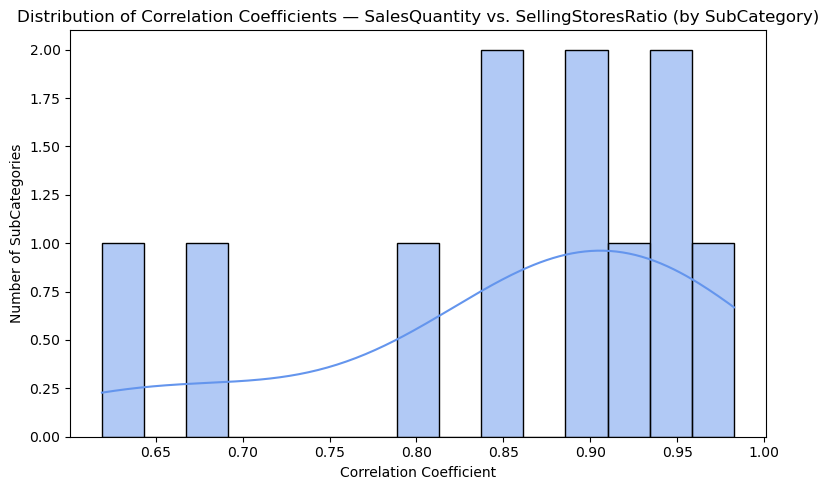


Highly positive correlations (> 0.5):
   SubCategory  Correlation
0     14iCK1vp     0.688933
1     8qImFANZ     0.982540
2     AunzRwr2     0.801269
3     Mm5PoR88     0.925789
4     OzTP0IWS     0.848037
5     UIpuKoxR     0.858755
6     WeHSHJQJ     0.888915
7     qE16z6jO     0.952601
8     sldfL1J4     0.945489
9     xdDed-iG     0.904085
10    yo2ZtUyf     0.619123

Highly negative correlations (< -0.5):
Empty DataFrame
Columns: [SubCategory, Correlation]
Index: []


In [22]:

# Calculate correlation by SubCategory
corr_by_subcat_ssr = (
    df.groupby('SubCategory')[['SalesQuantity', 'SellingStoresRatio']]
      .corr()
      .unstack()
      .iloc[:, 1]
      .rename('Correlation')
      .reset_index()
)

# Plot histogram
plt.figure(figsize=(8,5))
sns.histplot(
    data=corr_by_subcat_ssr,
    x='Correlation',
    bins=15,
    kde=True,
    color='cornflowerblue'
)
plt.title('Distribution of Correlation Coefficients — SalesQuantity vs. SellingStoresRatio (by SubCategory)')
plt.xlabel('Correlation Coefficient')
plt.ylabel('Number of SubCategories')
plt.tight_layout()
plt.show()

# Identify highly positive and negative correlations
high_corr_subcats = corr_by_subcat_ssr[corr_by_subcat_ssr['Correlation'] > 0.5]
low_corr_subcats  = corr_by_subcat_ssr[corr_by_subcat_ssr['Correlation'] < -0.5]

print("\nHighly positive correlations (> 0.5):")
print(high_corr_subcats)

print("\nHighly negative correlations (< -0.5):")
print(low_corr_subcats)


# Check for Seasonality - relationship between SalesQuantities and WeekIdentifier

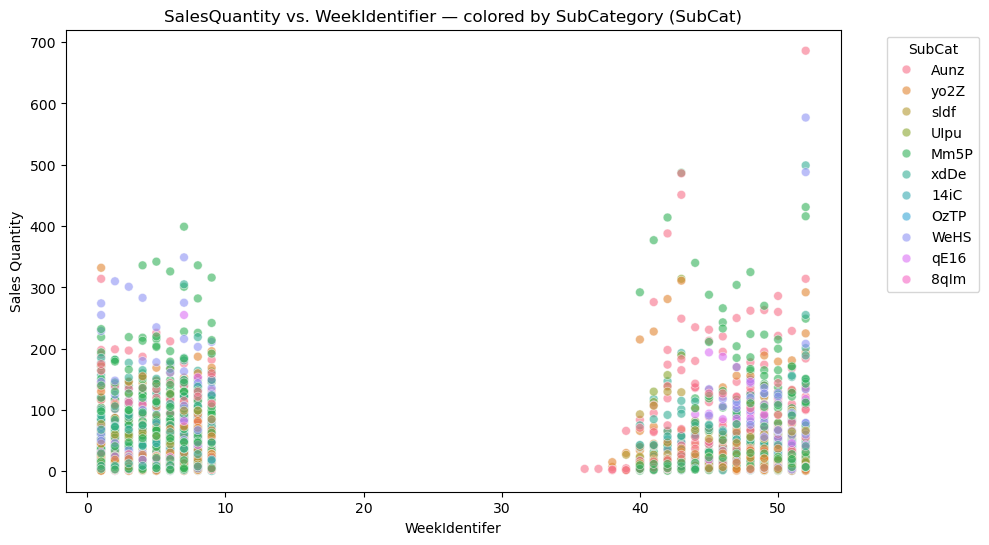

In [18]:
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=df,
    x='WeekIdentifier',
    y='SalesQuantity',
    hue='SubCat',
    alpha=0.6,         # transparency helps with overlap
    s=40               # point size
)

plt.title('SalesQuantity vs. WeekIdentifier — colored by SubCategory (SubCat)')
plt.xlabel('WeekIdentifer')
plt.ylabel('Sales Quantity')
plt.legend(title='SubCat', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout
plt.savefig("2_Seasonality.png", dpi=300, bbox_inches='tight')
plt.show()


### Key Takeaways from SalesQuantity and WeekIdentifier analysis

**Assuming the week identifier follows calendar weeks, we do not have data for spring and summer:**
    
- The scatterplot shows no correlation between SalesQuantity and WeekIdentifier

# Check is NewBasePrice is correlated to SellingStoresRatio

<Axes: >

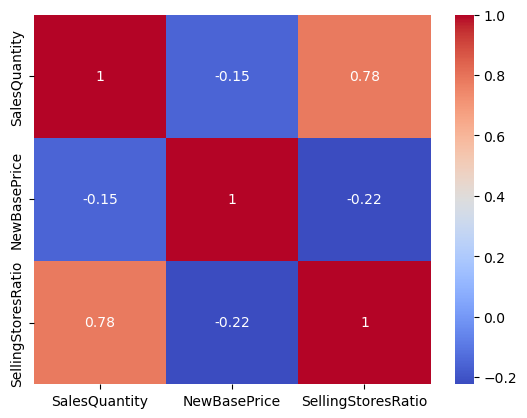

In [24]:
corr = df[['SalesQuantity', 'NewBasePrice', 'SellingStoresRatio']].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm')

**There is no correlation between NewBasePrice and SalesQuantity:**

In [25]:
# Save file to CSV file
df.to_csv("2_Sales_Data_EDA.csv", index=False)